# Importing the needed libraries

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

#sklearn specific
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, silhouette_score

In [6]:
#colors to create better visualizations
colors = ['#1FC17B', '#78FECF', '#555B6E', '#CC998D', '#429EA6',
        '#153B50', '#8367C7', '#EE6352', '#C287E8', '#F0A6CA', 
        '#521945', '#361F27', '#828489', '#9AD2CB', '#EBD494', 
        '#53599A', '#80DED9', '#EF2D56', '#446DF6', '#AF929D']

# Dataset Creation and Preprocessing

In [7]:
#make datasets with 100 features, around 20 clusters, having 100000 rows and lying between -1 to 1
X, y = make_blobs(n_features=100, centers=20, n_samples=100000, cluster_std=0.5, 
                  random_state=4, center_box=[-1, 1])

In [8]:
#split the data into training and testing data at 9:1 proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=4)

#scale the training and testing data separately
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Baseline Model - PCA ( 2 components)

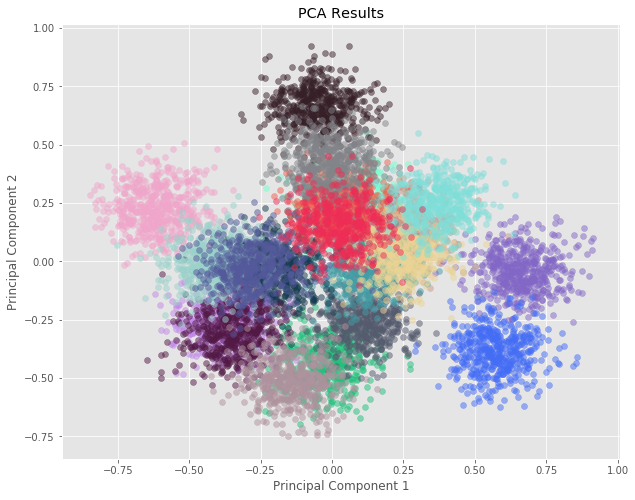

In [38]:
#fir the pca on training data, extract just 2 components and transform the test data
pca = PCA(n_components=2)
pca.fit(X_train)

pca_results = pca.transform(X_test)

#plot the data against the 2 principal components
unique_labels = np.unique(y_test)

plt.figure(figsize = (10,8))
for index, unique_label in enumerate(unique_labels):
    data = pca_results[y_test==unique_label]
    plt.scatter(data[:,0], data[:,1], alpha=0.5,c=cols[index])
    
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('PCA Results', fontsize = 20)
plt.show()

The data is segregated into clusters on the 2 components. The clusters look distinct but they overlap somewhat.


# Autoencoder Training


In [43]:
#build an encoder set up with 100, 150,100, 50, 2 neurons and build the decoder with the same number of neurons
autoencoder = MLPRegressor(alpha=1e-15, 
                           hidden_layer_sizes=(100, 150, 100, 50, 2, 50, 100, 150, 100), 
                           random_state=4, max_iter=25000)

autoencoder.fit(X_train, X_train)

MLPRegressor(activation='relu', alpha=1e-15, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 150, 100, 50, 2, 50, 100, 150, 100),
             learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
             max_iter=25000, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=4, shuffle=True,
             solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [53]:
#get the autoencoder model layer coefficient and biases
Coef = autoencoder.coefs_
biases = autoencoder.intercepts_

#just take the encoder weights, leave the decoder
encoder_weights = Coef[0:5]
encoder_biases = biases[0:5]

In [54]:
#build the dimension reducer using weights from the autoencoder
def encoder(encoder_weights, encoder_biases, data):
    ae_results = data
    for index, (Coef, biases) in enumerate(zip(encoder_weights, encoder_biases)):
        
        #if last layer, dont apply relu. Else, apply relu
        if index+1 == len(encoder_weights):
            ae_results = ae_results@Coef+biases 
        else:
            ae_results = np.maximum(0, ae_results@Coef+biases)
    return ae_results
            
ae_results = encoder(encoder_weights, encoder_biases, X_test)

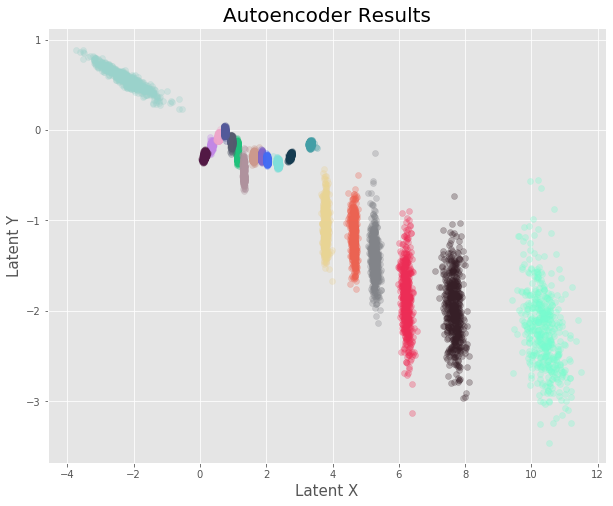

In [58]:
unique_labels = np.unique(y_test)

plt.figure(figsize = (10,8))
for index, unique_label in enumerate(unique_labels):
    latent_space = ae_results[y_test==unique_label]
    plt.scatter(latent_space[:,0], latent_space[:,1], alpha=0.3, c=cols[index])

plt.xlabel('Latent X', fontsize = 15)
plt.ylabel('Latent Y', fontsize = 15)
plt.title('Autoencoder Results', fontsize = 20)
plt.show()

The clusters from the autoencoder are well separated, distictly placed and far from each other compared to the clusters from the PCA. This can lead us to conclude that autoencoders could potentially be a better dimension reduction technique than PCA. They may need more data and more computational resources, but they can give much better results.

In [59]:
print("The Silhouette score of test data is {:.3f}".format(silhouette_score(X_test, y_test)))
print("The Silhouette score of PCA is {:.3f}".format(silhouette_score(pca_results, y_test)))
print("The Silhouette score of Autoencoders is {:.3f}".format(silhouette_score(ae_results, y_test)))

The Silhouette score of test data is 0.289
The Silhouette score of PCA is 0.134
The Silhouette score of Autoencoders is 0.764


The silhouette score of autoencoders is much higher than PCA, and surprisingly higher than the original test data. It says that the autoencoder version of representing the data in 2 components is a better representation in terms of cluster segregation than the original test data.

In [1]:
#import all the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers

Using TensorFlow backend.


In [3]:
input_dim = 100  # 8
encoding_dim = 2 #Since we extracted 4 features from PCA

# Number of neurons in each Layer [8, 7, 5, 5, 4] of encoders
#build the encoder
input_layer = Input(shape=(input_dim, ))
encoder_layer_1 = Dense(150,activation="linear")(input_layer)
encoder_layer_2 = Dense(100,activation="linear")(encoder_layer_1)
encoder_layer_3 = Dense(50,activation="linear")(encoder_layer_2)
encoder_layer_4 = Dense(encoding_dim, activation="linear")(encoder_layer_3)


In [28]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 35,402
Trainable params: 35,402
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Create encoder model
encoder = Model(inputs=input_layer, outputs=encoder_layer_4)
encoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

encoder_history = encoder.fit(X_train, y_train, epochs=200, shuffle=False, verbose=0)

ValueError: Error when checking target: expected dense_4 to have shape (2,) but got array with shape (1,)

In [13]:


# Create the dataset and merge the data with target variable
encoded_data = pd.DataFrame(encoder.predict(X_train))
encoded_data.columns = ['factor_1', 'factor_2']

finalDf_AE = pd.concat([encoded_data, pd.DataFrame(y_train)], axis = 1)

TypeError: concat() got an unexpected keyword argument 'columns'

In [20]:
finalDf_AE['ClusterID']  = finalDf_AE.iloc[:,-1]

In [21]:
finalDf_AE

,factor_1,factor_2,0,ClusterID
0,0.297152,-0.571263,16,16
1,0.405568,-0.607403,11,11
2,0.567665,-0.769567,13,13
3,0.445774,-0.399601,16,16
4,0.586415,-0.715037,10,10
5,0.766142,-0.289717,14,14
6,0.621553,-0.549901,18,18
7,0.492588,-0.942810,8,8
8,0.393426,-0.333521,15,15
9,0.442223,-0.654389,10,10


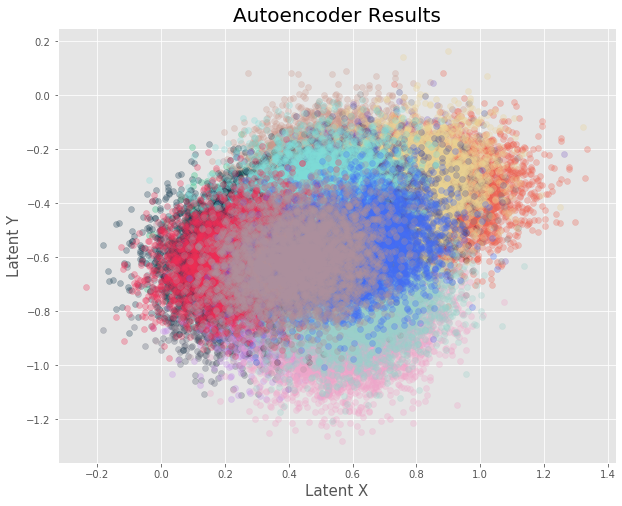

In [24]:
unique_labels = np.unique(y_train)

plt.figure(figsize = (10,8))
for index, unique_label in enumerate(unique_labels):
    latent_space = finalDf_AE[y_train==unique_label]
    plt.scatter(latent_space.iloc[:,0], latent_space.iloc[:,1], alpha=0.3, c=colors[index])

plt.xlabel('Latent X', fontsize = 15)
plt.ylabel('Latent Y', fontsize = 15)
plt.title('Autoencoder Results', fontsize = 20)
plt.show()